Quantization Error: 0.11815097523221106
Random SOM Error: 0.44970225780063466
Improvement Factor: 3.806166279345564
Cross-modal accuracy: 0.1865
Chance level: 0.0044444444444444444
Improvement over chance: 41.9625


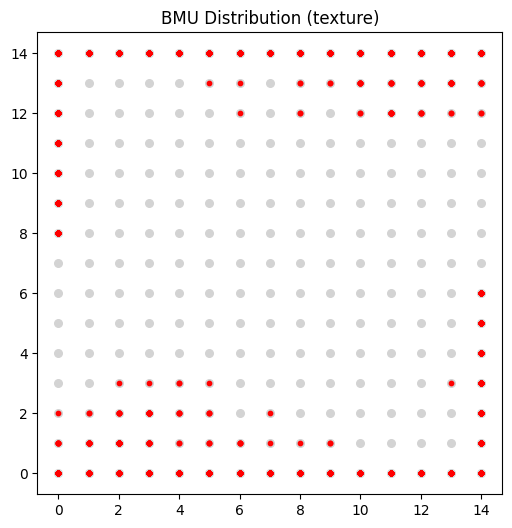

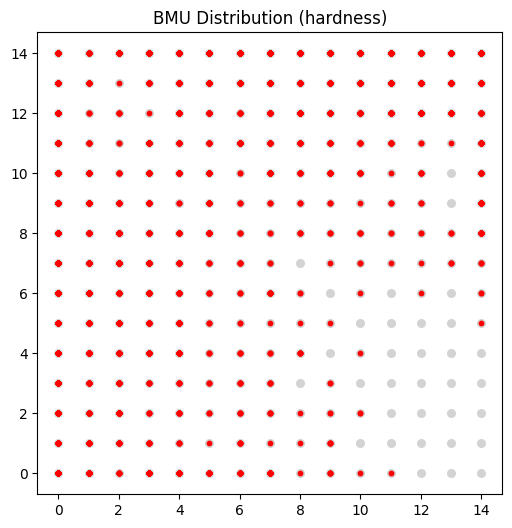

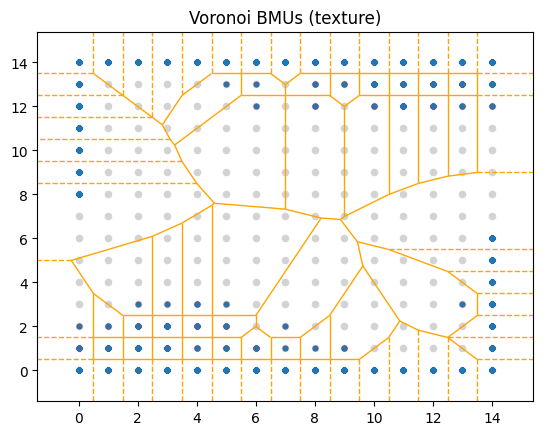

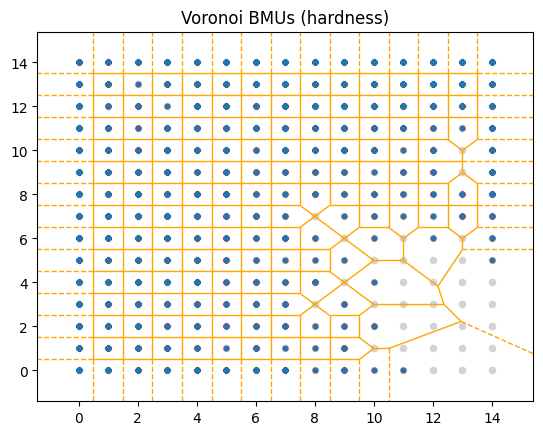

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# ======================================================
# SIMULATED MULTIMODAL DATA (PAPER-STYLE)
# ======================================================

def simulate_texture(n):
    """
    Texture-like sensory modality:
    Oscillatory + nonlinear patterns with noise
    """
    t = np.linspace(0, 4 * np.pi, n)
    X = np.column_stack([
        np.sin(t),
        np.cos(2 * t),
        np.sin(3 * t)
    ])
    return X + 0.05 * np.random.randn(n, 3)

def simulate_hardness(n):
    """
    Hardness-like sensory modality:
    Monotonic physical properties with noise
    """
    h = np.linspace(0, 1, n)
    X = np.column_stack([
        h,
        h ** 2,
        np.sqrt(h)
    ])
    return X + 0.03 * np.random.randn(n, 3)

np.random.seed(42)
N_SAMPLES = 2000

X_texture = simulate_texture(N_SAMPLES)
X_hardness = simulate_hardness(N_SAMPLES)

modalities = {
    "texture": X_texture,
    "hardness": X_hardness
}

# ======================================================
# ASSOCIATIVE SELF-ORGANIZING MAP (A-SOM)
# ======================================================

class ASOM:
    def __init__(self, modalities, N=15, seed=None):
        if seed is not None:
            np.random.seed(seed)

        self.modalities = {k: np.asarray(v) for k, v in modalities.items()}
        self.mod_names = list(self.modalities.keys())
        self.N = N
        self.map_nodes = N * N

        x, y = np.meshgrid(range(N), range(N))
        self.c = np.vstack([y.flatten(), x.flatten()]).T

        self.som_weights = {
            m: np.random.rand(self.map_nodes, v.shape[1])
            for m, v in self.modalities.items()
        }

        self.assoc = {}
        for i in range(len(self.mod_names)):
            for j in range(i + 1, len(self.mod_names)):
                a, b = self.mod_names[i], self.mod_names[j]
                self.assoc[(a, b)] = np.zeros((self.map_nodes, self.map_nodes))

    def _find_bmu(self, weights, vector):
        return np.argmin(np.linalg.norm(weights - vector, axis=1))

    # ---------------------
    # Training (Paper-aligned)
    # ---------------------
    def train(self, epochs=3000, alpha_init=0.1):
        n = len(next(iter(self.modalities.values())))
        alpha = alpha_init

        sigma_init = self.N / 2
        sigma_final = 1.0

        for t in range(epochs):
            i = np.random.randint(n)

            sigma = sigma_init * (1 - t / epochs) + sigma_final * (t / epochs)

            bmus = {}
            for m in self.mod_names:
                x = self.modalities[m][i]
                bmus[m] = self._find_bmu(self.som_weights[m], x)

            for m in self.mod_names:
                x = self.modalities[m][i]
                w = self.som_weights[m]
                d = np.linalg.norm(self.c - self.c[bmus[m]], axis=1)
                h = np.exp(-(d ** 2) / (2 * sigma ** 2))
                w += alpha * h[:, None] * (x - w)

            for (a, b), M in self.assoc.items():
                M[bmus[a], bmus[b]] += 1

            alpha *= 0.999

        for k in self.assoc:
            self.assoc[k] /= np.max(self.assoc[k])

    # ---------------------
    # Metrics
    # ---------------------
    def quantization_error(self):
        errs = []
        for m in self.mod_names:
            for x in self.modalities[m]:
                bmu = self._find_bmu(self.som_weights[m], x)
                errs.append(np.linalg.norm(x - self.som_weights[m][bmu]))
        return np.mean(errs)

    # ---------------------
    # Cross-modal recall
    # ---------------------
    def generate_cross(self, stim_mod, stim_vec):
        bmu = self._find_bmu(self.som_weights[stim_mod], stim_vec)
        out = {}
        for (a, b), M in self.assoc.items():
            if a == stim_mod:
                out[b] = np.argmax(M[bmu])
            elif b == stim_mod:
                out[a] = np.argmax(M[:, bmu])
        return out

    # ---------------------
    # Visualization helpers
    # ---------------------
    def plot_bmu_centers(self, modality):
        centers = np.array([
            self._find_bmu(self.som_weights[modality], x)
            for x in self.modalities[modality]
        ])
        plt.figure(figsize=(6, 6))
        plt.scatter(self.c[:, 0], self.c[:, 1], c='lightgray', s=30)
        plt.scatter(self.c[centers, 0], self.c[centers, 1], c='red', s=10)
        plt.title(f"BMU Distribution ({modality})")
        plt.show()

    def plot_bmu_voronoi(self, modality):
        centers = np.array([
            self._find_bmu(self.som_weights[modality], x)
            for x in self.modalities[modality]
        ])
        pts = self.c[centers]
        vor = Voronoi(pts)
        voronoi_plot_2d(vor, show_vertices=False, line_colors='orange')
        plt.scatter(self.c[:, 0], self.c[:, 1], c='lightgray', s=20)
        plt.scatter(pts[:, 0], pts[:, 1], c='red', s=10)
        plt.title(f"Voronoi BMUs ({modality})")
        plt.show()

# ======================================================
# TRAIN MODEL
# ======================================================

msom = ASOM(modalities, N=15, seed=42)
msom.train(epochs=3000, alpha_init=0.1)

# ======================================================
# EVALUATION
# ======================================================

qe = msom.quantization_error()
print("Quantization Error:", qe)

# Random baseline
rand_errs = []
for m in modalities:
    W = np.random.rand(msom.map_nodes, modalities[m].shape[1])
    for x in modalities[m]:
        bmu = np.argmin(np.linalg.norm(W - x, axis=1))
        rand_errs.append(np.linalg.norm(x - W[bmu]))

qe_rand = np.mean(rand_errs)
print("Random SOM Error:", qe_rand)
print("Improvement Factor:", qe_rand / qe)

# ======================================================
# CROSS-MODAL ACCURACY
# ======================================================

correct = 0
for i in range(N_SAMPLES):
    pred = msom.generate_cross("texture", X_texture[i])["hardness"]
    true = msom._find_bmu(msom.som_weights["hardness"], X_hardness[i])
    if pred == true:
        correct += 1

acc = correct / N_SAMPLES
chance = 1 / msom.map_nodes

print("Cross-modal accuracy:", acc)
print("Chance level:", chance)
print("Improvement over chance:", acc / chance)

# ======================================================
# VISUALIZATIONS
# ======================================================

msom.plot_bmu_centers("texture")
msom.plot_bmu_centers("hardness")
msom.plot_bmu_voronoi("texture")
msom.plot_bmu_voronoi("hardness")